In [78]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [79]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [80]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 1024
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [81]:
# Configure the index vectors
num_k_per_dim = 512
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
hk_list = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [ ]:
# Specify the dynamic system 
import infomeasure as im
divergence = []
dt = 0.01
tsteps = 100001
ud = .2 # desired velocity in m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

# start SMC iteration
#xt = np.random.uniform(low=0.2, high=0.8, size=(2,)) # inital state
xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2)) # trajectory
ck_list_update = np.zeros(ks.shape[0])  # trajectory coefficients (update over time, not normalized)
metric_log = []  # record ergodic metric at each step
timeit = []
Wasserstein = []
for t in range(tsteps):
    fk_xt_all = np.prod(np.cos(np.pi * ks / L_list * xt), axis=1) / hk_list
    ck_list_update += fk_xt_all * dt

    dfk_xt_all = np.array([
        -np.pi * ks[:,0] / L_list[0] * np.sin(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.cos(np.pi * ks[:,1] / L_list[1] * xt[1]),
        -np.pi * ks[:,1] / L_list[1] * np.cos(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.sin(np.pi * ks[:,1] / L_list[1] * xt[1]),
    ]) / hk_list



    # step 4: compute control signal
    bt = np.sum(lamk_list * ((ck_list_update / (t*dt+dt)) - phik_list) * dfk_xt_all, axis=1) #+ barrier_weight * dB
    ut = -ud * bt / (np.linalg.norm(bt) + 1e-8)

    # print('ut: ', np.linalg.norm(ut))a
    
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square(phik_list - ck_list_update / (t*dt+dt)))
    
    metric_log.append(erg_metric)
    if not t % 10000 and t != 0:#t == 1000 or t == 10000 or t == 100000 or t == 1000000:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}")  
        mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])
        KL = im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')
        divergence.append(KL)
        print(KL, 'emp')


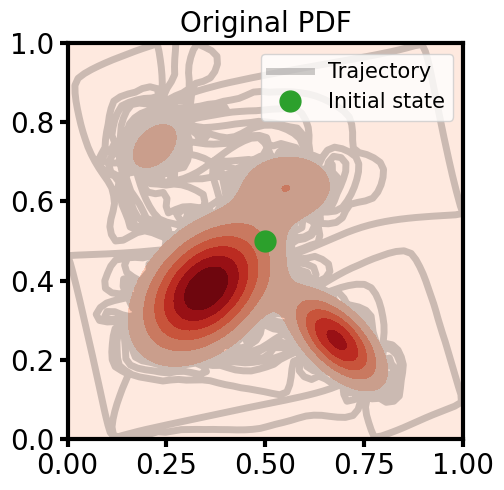

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [ ]:
#np.save(rf"Divergence_Data/Fourier_{num_k_per_dim}.npy", np.array(divergence))